# 머신러닝을 활용한 코스피 지수예측

# WHY
- 코스피 지수를 예측할수만 있다면, 코스피 ETF 또는 인버스 ETF를 이용해 돈을 복사할 수 있을것이다.
- 머신러닝과 다양한 지표(금 가격, 은 가격, 미국증시 등..)를 활용한다면, 지수를 예측할 수 있지 않을까??

# DATA
- Investing.com
  - Gold, Silver, Brent-oil, WTI-oil, S&P index, Kosdaq, Kospi,  
   한국 국채 10년 수익률, 미국 국채 10년 수익률, 엔-원 환율, 원-달러 환율

# HOW
- 데이터 수집 방법 : 웹 다운로드 - www.investing.com 후 구글드라이브 저장
- 데이터 정제 방법 : Python, pandas 라이브러리
- 활용한 모델 : ARIMA 모델, Random Forest Classifier, Random Forest Regressor
- 예측 방법 : Target 외 모든 데이터를 Arima 모델로 예측하고,  
 예측된 값에 Random Forest Classifier를 적용해 0 - 3 데이터로 예측


# RESULT
- ARIMA 모델로 예측한 값은 결과가 대부분 선형적으로 나타나고, 정확도가 떨어짐.
- Random Forest 모델로 예측한 값은 매우 정확한 결과를 보였으나,  
내일의 KOSPI를 알기 위해 내일의 Gold Silver S&P 등 모든 데이터를 정확히 예측해야 한다는 단점
- 결과적으로 두 모델을 합쳤을경우 정상적으로 예측될것으로 생각했으나, 생각한 대로 되지 않음.

## OPINION
- Random Forest 모델은 매우 정확하게 예측할 수 있었지만, 시계열 예측방식인 ARIMA 모델은 아무리 파라미터를 조정해도 실제 값을 따라갈 수 없었음. 
- 대략적인 값을 넣어도 Random Forest 모델이 정상작동할 줄 알았으나, 예상과는 달리 매우 부정확한 결과를 도출함. 
- 돈 벌 생각에 신나서 코드 짜는건 역시 재미있음.

## CODE

###Summary
 - 코스피 지수의 단기적 동향을 예측하여, 선물옵션을 통한 단기적 수익실현 및 투자지표로서의 활용이 가능하도록 합니다.
 - 추후 동일한 모델을 부동산 시장 등에 적용시키기 위해, 데이터에 맞춰 쉽게 변형할 수 있도록 작성합니다.
 - 두 개 이상의 예측 모델을 활용하여 그 결과를 토대로 서로의 예측을 개선할 수 있게 합니다.
 - ARIMA 로 Feature 수치를 대략적으로 예측하고, 예측된 데이터를 토대로 Random Forest를 활용해 Target Value를 구합니다.

## 1. Data Wrangling

In [ ]:
%%capture
from google.colab import drive
import io
import pandas as pd
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWhYhdBXzB0Fbu9BfjNO-B5mISXNmFttRtUr5iocyNiP8Ubgz2dEDjM


In [ ]:
# 데이터
import datetime
import numpy as np

def get_data(NAME,col):
  # 1. 데이터 가져오기
  df = pd.read_csv('drive/MyDrive/Project/Data_For_Kospi/' + NAME + '.csv')

  # 2. 종가, 거래량, 변동% 제외한 Feature 제거 (중복 Issue 가능성)
  df = df.drop(['오픈','고가','저가'], axis=1)

  # 3. 컬럼명 변경 (원본 데이터마다 Columns 다름, 오류처리구문 추가)
  columns_volp = ['date' , col + '_' + 'enpr' , col + '_' + 'volm' , col + '_' + 'chag']
  columns_volm = ['date' , col + '_' + 'enpr' , col + '_' + 'chag']
  try:
    df.columns = columns_volp
  except:
    df.columns = columns_volm

  # 4. 자료형 변경
  for col in df.columns:
    temp_list = []
    for i in df[col]:
      
      try:
        temp = i.replace('년','') # ER : SILVER ('sv_enpr',) 23.925 에서 에러발생 / float를 replace 하다보니 문제 / 츄라이로 넘겨서 해결
        temp = temp.replace('월','')
        temp = temp.replace('일','')
        temp = temp.replace(' ','-') # 수정 / Debug
        temp = temp.replace(',','')
        temp = temp.replace('K','000')
        temp = temp.replace('%','')
      except:
        temp_list.append(i) # 첨부터 float인 자료형을 list에 저장 / ER : append(temp) 해놓고 뭐가문젠지 한참 찾았네..
        continue # ER : 컬럼에 리스트 적용시 길이가 달라 에러발생 / 아래 츄라이문 하면서 중복적용된게 문제 / 컨티뉴로 돌려보내서 해결
        # ER : 뒷쪽 구문 먹어버려서 'sv_enpr' 에 의미가 다른 값이 들어감
      try:
        temp = float(temp)
        temp_list.append(temp) # float 로 변경된 자료형을 list에 저장
      except:
        try:
          #print(col, i, temp)
          temp = datetime.datetime.strptime(temp, '%Y-%m-%d').date()
          temp_list.append(temp) # datetime 로 변경된 자료형을 list에 저장
        except:
          temp = np.nan
          temp_list.append(temp) # NaN 으로 변경된 자료형을 list에 저장
    df[col] = temp_list # 변경된 리스트를 col 에 저장

  print(NAME,'=',df.shape) # Debug code / 으아아 같은기간 긁었는데 뭐가이렇게 달라

  # 5. 데이터프레임으로 반환
  return df

gd = get_data('GOLD','gd') # 금 시세
sv = get_data('SILVER','sv') # 은 시세
ob = get_data('OIL_BRENT','ob') # 브렌트유 시세
ow = get_data('OIL_WTI','ow') # WTI유 시세
sp = get_data('S&P','sp') # 미국 증시 S&P 500 지수
kd = get_data('KOSDAQ','kd') # 코스닥
kp = get_data('KOSPI','kp') # 코스피(Target)
kr = get_data('KR10','kr') # 한국 10년 국채 수익률
us = get_data('US10','us') # 미국 10년 국채 수익률
jk = get_data('JPY_KRW','jk') # 엔 - 원 환율
uk = get_data('USD_KRW','uk') # 달러 - 원 환율

gd.set_index('date', inplace = True)
sv.set_index('date', inplace = True)
ob.set_index('date', inplace = True)
ow.set_index('date', inplace = True)
sp.set_index('date', inplace = True)
kd.set_index('date', inplace = True)
kp.set_index('date', inplace = True)
kr.set_index('date', inplace = True)
us.set_index('date', inplace = True)
jk.set_index('date', inplace = True)
uk.set_index('date', inplace = True)

df = gd.join(sv, how='outer').join(ob, how='outer').join(ow, how='outer').join(sp , how='outer').join(kd , how='outer').join(kp , how='outer').join(kr , how='outer').join(us , how='outer').join(jk , how='outer').join(uk , how='outer')
print('\n','[joined df] =',df.shape)

# 결측치가 너무 많은 (1500 이상인) Feature 삭제
df = df.drop(['sp_volm','kd_volm','kp_volm'], axis = 1)

# 나머지 결측치는 선형 보간 (interpolation)
df_intp = df.interpolate()

# 보간 후에도 결측치 남아있는 행 삭제 (상위 2행, 시계열 데이터에 영향 주지 않음)
df = df_intp.dropna()

# 중복 값 있는지 확인 -> 없음
print('\n','[Duplicated check]','\n')
df.T.duplicated()

GOLD = (2642, 4)
SILVER = (3140, 4)
OIL_BRENT = (2604, 4)
OIL_WTI = (2635, 4)
S&P = (2537, 4)
KOSDAQ = (2485, 4)
KOSPI = (2484, 4)
KR10 = (3168, 3)
US10 = (3012, 3)
JPY_KRW = (2632, 3)
USD_KRW = (2632, 3)

 [joined df] = (3511, 29)

 [Duplicated check] 



gd_enpr    False
gd_volm    False
gd_chag    False
sv_enpr    False
sv_volm    False
sv_chag    False
ob_enpr    False
ob_volm    False
ob_chag    False
ow_enpr    False
ow_volm    False
ow_chag    False
sp_enpr    False
sp_chag    False
kd_enpr    False
kd_chag    False
kp_enpr    False
kp_chag    False
kr_enpr    False
kr_chag    False
us_enpr    False
us_chag    False
jk_enpr    False
jk_chag    False
uk_enpr    False
uk_chag    False
dtype: bool

## 2. Test - ARIMA Model

  - 전통적인 시계열 예측 방법
    - AR(Autoregression) 모델 : 자신의 과거를 정보로 사용하는 개념
    - MA(Moving Average) 모델 : 이번 항에서의 오차를 이용, 현재 항의 상태를 추론
    - 두가지가 합쳐진 것을 ARMA 모델이라고 함
    - ARIMA(Autoregressice Integrated Moving Average)모델은 ARMA 모델에 추세 변동의 경향성까지 반영한 방법

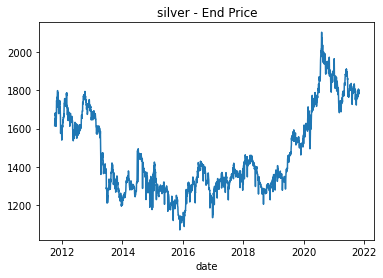

In [ ]:
import matplotlib.pyplot as plt
df.gd_enpr.plot()
plt.title('silver - End Price')
plt.show()

In [ ]:
step = 10 # 테스트 데이터 분리 할 일자 수
test_df = df.gd_enpr.drop(df.gd_enpr.index[-1 * step :-1])
test_df = test_df.drop(test_df.index[-1])
test_df

date
2011-10-04    1614.70
2011-10-05    1640.30
2011-10-06    1651.90
2011-10-07    1634.50
2011-10-09    1652.05
               ...   
2021-10-18    1765.70
2021-10-19    1770.50
2021-10-20    1784.90
2021-10-21    1781.90
2021-10-22    1796.30
Name: gd_enpr, Length: 3499, dtype: float64

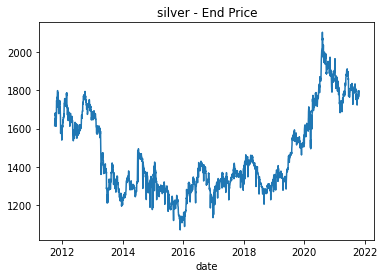

In [ ]:
import matplotlib.pyplot as plt
test_df.plot()
plt.title('silver - End Price')
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

model = ARIMA(test_df.values, order = (2,0,2))
# AR = 3, 차분 = 1, MA = 2 파라미터로 ARIMA 모델을 학습한다.

In [ ]:
# ARIMA 모델 학습
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3499
Model:                     ARMA(2, 2)   Log Likelihood              -14946.344
Method:                       css-mle   S.D. of innovations             17.321
Date:                Thu, 11 Nov 2021   AIC                          29904.689
Time:                        00:13:30   BIC                          29941.650
Sample:                             0   HQIC                         29917.880
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1536.5509    121.926     12.602      0.000    1297.580    1775.522
ar.L1.y        1.5150      0.046     32.863      0.000       1.425       1.605
ar.L2.y       -0.5157      0.046    -11.207      0.0

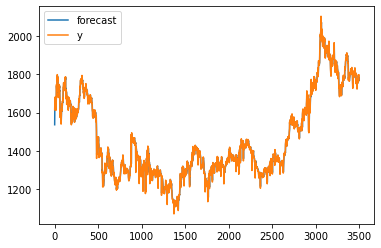

In [ ]:
# 학습 데이터에 대한 예측 결과
fig = model_fit.plot_predict()

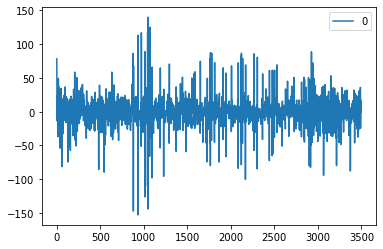

In [ ]:
# 실제값과 예측값 사이의 오차 변동
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

In [ ]:
# 모델 평가
forecast_data = model_fit.forecast(steps=step) 

test_df_c = df.gd_enpr[len(df.gd_enpr) - step:]
test_df_c

date
2021-10-23    1799.800
2021-10-24    1803.300
2021-10-25    1806.800
2021-10-26    1793.400
2021-10-27    1798.800
2021-10-28    1802.600
2021-10-29    1783.900
2021-10-30    1782.575
2021-10-31    1781.250
2021-11-01    1785.550
Name: gd_enpr, dtype: float64

In [ ]:
# 마지막 5월의 예측 데이터
pred_y = forecast_data[0].tolist()

# 실제 5월의 데이터
test_y = test_df_c.values

# 마지막 5월의 예측 데이터 최소값
pred_y_lower = []

# 마지막 5월의 예측 데이터 최대값
pred_y_upper = []

In [ ]:
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

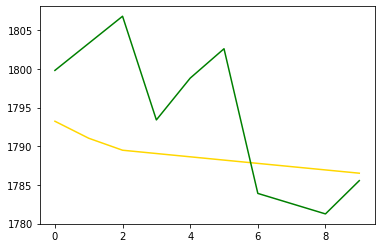

In [ ]:
# 5,1,2 모델이 예측한 가격 그래프
plt.plot(pred_y, color = 'gold')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

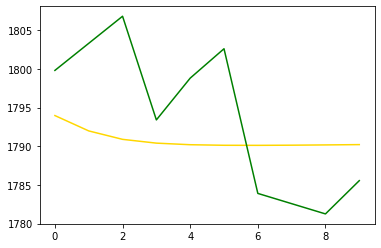

In [ ]:
# 5,1,2 모델이 예측한 가격 그래프
plt.plot(pred_y, color = 'gold')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

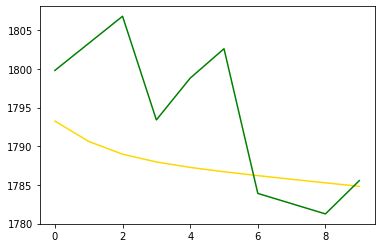

In [ ]:
# 5,1,2 모델이 예측한 가격 그래프
plt.plot(pred_y, color = 'gold')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

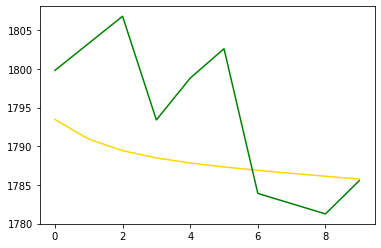

In [ ]:
# 5,1,2 모델이 예측한 가격 그래프
plt.plot(pred_y, color = 'gold')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

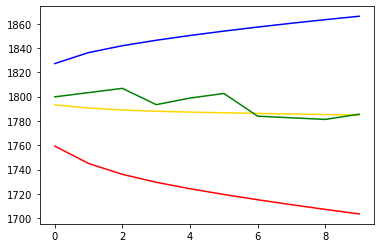

In [ ]:
# 5,1,2 모델이 예측한 가격 그래프 (최저, 최고)
plt.plot(pred_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

In [ ]:
# 위의 내용을 df_enpr, steps 로 함수화
def arima(col,step=10): # df.gd_enpr,10
  from statsmodels.tsa.arima_model import ARIMA
  import statsmodels.api as sm
  test_df = col.drop(col.index[-1 * step :-1])
  test_df = test_df.drop(test_df.index[-1])
  try:
    model = ARIMA(test_df.values, order = (1,1,1))
    model_fit = model.fit(trend = 'c', full_output = True, disp = True)
  except:
    try:
      model = ARIMA(test_df.values, order = (2,1,2))
      model_fit = model.fit(trend = 'c', full_output = True, disp = True)
    except:
      try:
        model = ARIMA(test_df.values, order = (3,1,3))
        model_fit = model.fit(trend = 'c', full_output = True, disp = True)
      except:
        try:
          model = ARIMA(test_df.values, order = (5,1,5))
          model_fit = model.fit(trend = 'c', full_output = True, disp = True)
        except:
          model = ARIMA(test_df.values, order = (5,2,1))
          model_fit = model.fit(trend = 'c', full_output = True, disp = True)






  forecast_data = model_fit.forecast(steps=step) 

  test_df_c = col[len(col) - step:]
  test_df_c

  # 예측 데이터
  pred_y = forecast_data[0].tolist()

  # 실제 데이터
  test_y = test_df_c.values

  # 예측 데이터 최소값
  pred_y_lower = []

  # 예측 데이터 최대값
  pred_y_upper = []

  for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)
  
  	
  #fig = plt.figure(figsize=(5,5))

  # 모델이 예측한 가격 그래프
  plt.plot(pred_y, color = 'gold')

  # 모델이 예측한 최저 가격 그래프
  #plt.plot(pred_y_lower, color = 'red')

  # 모델이 예측한 최고 가격 그래프
  #plt.plot(pred_y_upper, color = 'blue')

  # 실제 가격 그래프
  plt.plot(test_y, color = 'green')


Progress:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


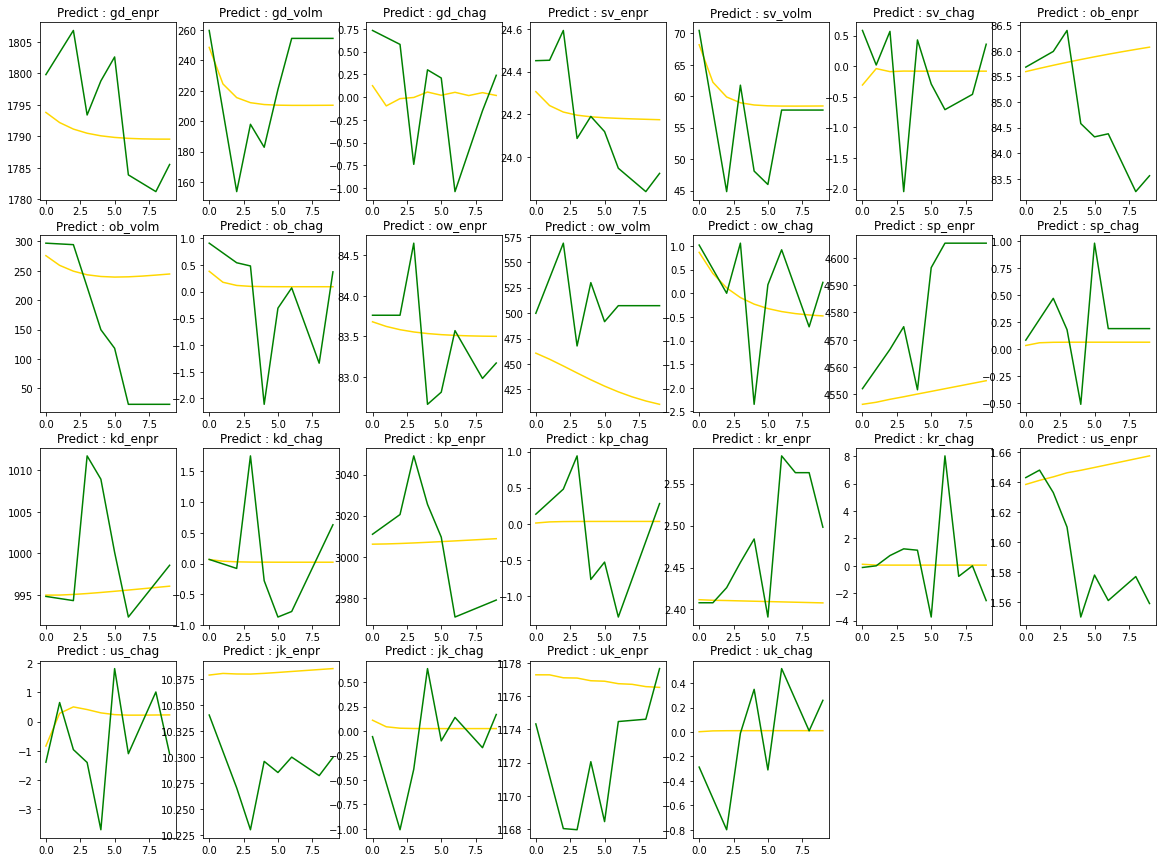

In [ ]:
from tqdm import notebook

grid = (1,3)
n = 0

fig = plt.figure(figsize=(20,15))
for i in notebook.tqdm(df.columns, desc='Progress'):
    n += 1
    plt.subplot(4,7,n)
    plt.title("Predict : "+ i)
    arima(df[i])


plt.show()

ARIMA 모델이 그럭저럭 예측하는것을 확인했다.

##3. Apply - ARIMA Model

In [ ]:
# 데이터 축소 함수 (검증용)
from datetime import date

def cut_data(df, first = 0, last = 0): # cut_data(df, '2021-09-30', '2021-10-30')
  if first == 0:
    first = str(df.index[0])
  if last == 0:
    last = str(df.index[-1])

  cdf = (df.index >= date.fromisoformat(first)) & (df.index <= date.fromisoformat(last))
  return df[cdf]

# ARIMA 예측 함수
def arima(col,step=10): # df.gd_enpr,10
  from statsmodels.tsa.arima_model import ARIMA
  import statsmodels.api as sm

  try:
    model = ARIMA(col.values, order = (2,1,2))
    model_fit = model.fit(trend = 'c', full_output = True, disp = True)
    print('Model : (2,1,2)')
  except:
    try:
      model = ARIMA(col.values, order = (5,1,2))
      model_fit = model.fit(trend = 'c', full_output = True, disp = True)
      print('Model : (5,1,2)')
    except:
      model = ARIMA(col.values, order = (1,0,1))
      model_fit = model.fit(trend = 'c', full_output = True, disp = True)
      print('Model : (5,1,2)')


  forecast_data = model_fit.forecast(steps=step) 

  pred_y = forecast_data[0].tolist()
  return pred_y

결과 검증 및 비교를 위해 데이터 축소

In [ ]:
cdf = cut_data(df, 0, 0) # 최초 / 최종

In [ ]:
cdf.index[-1]

datetime.date(2021, 11, 1)

In [ ]:
cdf = cdf.drop(['gd_chag', 'us_chag','jk_chag','uk_chag'], axis=1) # ARIMA 모델 적용시 에러유발 - 삭제

예측 데이터프레임 생성

In [ ]:
from tqdm import notebook

pred_df = pd.DataFrame([])
for col in notebook.tqdm(cdf.columns, desc='Progress'):
  pred_df[col] = arima(cdf[col])
  print('Now processing : ',col)

Progress:   0%|          | 0/22 [00:00<?, ?it/s]

Now processing :  gd_enpr
Now processing :  gd_volm
Now processing :  sv_enpr
Now processing :  sv_volm
Now processing :  sv_chag
Now processing :  ob_enpr
Now processing :  ob_volm
Now processing :  ob_chag
Now processing :  ow_enpr
Now processing :  ow_volm
Now processing :  ow_chag
Now processing :  sp_enpr
Now processing :  sp_chag
Now processing :  kd_enpr
Now processing :  kd_chag
Now processing :  kp_enpr
Now processing :  kp_chag
Now processing :  kr_enpr
Now processing :  kr_chag
Now processing :  us_enpr
Now processing :  jk_enpr
Now processing :  uk_enpr


In [ ]:
pred_df # Test dataset

,gd_enpr,gd_volm,sv_enpr,sv_volm,sv_chag,ob_enpr,ob_volm,ob_chag,ow_enpr,ow_volm,ow_chag,sp_enpr,sp_chag,kd_enpr,kd_chag,kp_enpr,kp_chag,kr_enpr,kr_chag,us_enpr,jk_enpr,uk_enpr
0,1786.345065,247.497425,23.871051,56.643197,0.281246,83.548102,97.112416,0.109875,83.185032,477.942570,0.450774,4605.552346,0.141140,999.179540,0.200175,2979.300166,0.023757,2.499854,-0.007339,1.559458,10.297504,1177.718158
1,1786.144846,234.448906,23.907563,56.630164,0.154937,83.534780,148.504318,0.140432,83.191587,449.865936,0.068620,4605.249308,0.048645,999.933736,0.100844,2981.825290,0.060001,2.502813,0.161628,1.559674,10.296851,1177.770224
2,1786.444432,237.386874,23.949663,56.163415,0.004068,83.520853,185.075837,0.112475,83.172642,429.710142,-0.252541,4608.708314,0.106994,1000.272229,0.078195,2982.778244,0.083917,2.507146,0.301058,1.560141,10.295216,1177.814430
3,1786.281582,229.293389,23.936276,56.382696,-0.079042,83.481895,207.377138,0.096759,83.188809,414.216940,-0.581531,4606.228350,0.046698,1000.576580,0.085042,2983.846071,0.095410,2.508331,0.186337,1.560628,10.293416,1177.761082
4,1786.641117,234.051459,23.879580,56.128103,-0.205978,83.433392,221.202034,0.088870,83.217166,403.712968,-0.510074,4610.870272,0.098697,1000.723872,0.052824,2984.483310,0.043327,2.509628,0.174874,1.560796,10.292125,1177.725062
5,1786.552463,228.545707,23.882378,56.365275,-0.110156,83.380613,229.809863,0.090447,83.248276,397.819743,-0.552707,4608.274114,0.045054,1000.891080,0.033692,2985.136582,0.038994,2.510601,0.133069,1.560977,10.290689,1177.678926
6,1786.774862,232.040997,23.898251,56.175447,-0.025612,83.328582,235.030636,0.086806,83.268091,394.815602,-0.429008,4612.488789,0.086323,1000.999350,0.023966,2985.555656,0.036986,2.511919,0.167513,1.561057,10.289324,1177.647133
7,1786.725923,228.767225,23.894151,56.379912,0.011955,83.282372,238.367092,0.090397,83.273262,393.669199,-0.517546,4610.826469,0.050842,1001.126940,0.020042,2985.986652,0.035132,2.512915,0.139212,1.561110,10.287936,1177.610072
8,1786.872734,230.950022,23.893785,56.225932,0.009861,83.245468,240.348925,0.087190,83.263581,393.595959,-0.460943,4613.725099,0.079498,1001.241003,0.016504,2986.347792,0.029541,2.514129,0.171423,1.561125,10.286542,1177.586301
9,1786.861012,229.228721,23.906185,56.397778,0.005658,83.219925,241.660101,0.090596,83.243664,394.037497,-0.551254,4613.643711,0.055965,1001.369936,0.014587,2986.713297,0.030315,2.515022,0.141034,1.561118,10.285152,1177.557968


##4. Feature Engineering

Kospi 지수의 변동량에 따라 0에서 3까지의 정수값을 갖게 만들어보자.

In [ ]:
df.columns

Index(['gd_enpr', 'gd_volm', 'gd_chag', 'sv_enpr', 'sv_volm', 'sv_chag',
       'ob_enpr', 'ob_volm', 'ob_chag', 'ow_enpr', 'ow_volm', 'ow_chag',
       'sp_enpr', 'sp_chag', 'kd_enpr', 'kd_chag', 'kp_enpr', 'kp_chag',
       'kr_enpr', 'kr_chag', 'us_enpr', 'us_chag', 'jk_enpr', 'jk_chag',
       'uk_enpr', 'uk_chag'],
      dtype='object')

In [ ]:
df.kp_chag.describe()

count    3509.000000
mean        0.017162
std         0.931079
min        -8.390000
25%        -0.410000
50%         0.040000
75%         0.500000
max         8.600000
Name: kp_chag, dtype: float64

kp_chag 값에 따라 0은 -0.41 미만, 3은 0.5 이상으로 값을 만들면 되겠다.

In [ ]:
temp_list = []
for i in df.kp_chag:
  temp = round(i,2)
  
  if temp <= -0.41:
    n = 0
  elif temp <= 0.04:
    n = 1
  elif temp < 0.5:
    n = 2
  else:
    n = 3
  
  temp_list.append(n)

df['point'] = temp_list

In [ ]:
df2 = df.copy() # df 백업 1

In [ ]:
#df = df2.copy() # df 백업 2

In [ ]:
# df 에서 point 직접적으로 관련된 넘 제거 (Target Data Leak)
df = df.drop(['kp_chag','kp_enpr'], axis=1)

In [ ]:
target = 'point'

train =  cut_data(df, 0, '2018-10-30')
test =  cut_data(df, '2018-10-31')

val = cut_data(train, '2016-10-30')
train = cut_data(train, 0, '2016-10-29')

train.shape, val.shape, test.shape

((1704, 25), (719, 25), (1086, 25))

In [ ]:
# Train 에서 Target drop
features = train.drop(columns=[target]).columns

In [ ]:
# X, y 로 분리
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [ ]:
X_train.head() # point, kp_~~ 특성 제거됨

,gd_enpr,gd_volm,gd_chag,sv_enpr,sv_volm,sv_chag,ob_enpr,ob_volm,ob_chag,ow_enpr,ow_volm,ow_chag,sp_enpr,sp_chag,kd_enpr,kd_chag,kr_enpr,kr_chag,us_enpr,us_chag,jk_enpr,jk_chag,uk_enpr,uk_chag
date,,,,,,,,,,,,,,,,,,,,,,,,
2011-10-04,1614.70,0.160,-2.49,29.795,0.04,-3.11,99.790,264.830,-1.89,75.670,428.110,-2.50,1123.950,2.250,436.130,-3.010,3.80,-3.31,1.8170,3.890,15.59240,1.150,1198.900,1.560
2011-10-05,1640.30,0.110,1.59,30.317,0.18,1.75,102.730,215.940,2.95,79.680,336.070,5.30,1144.030,1.790,421.180,-3.430,3.78,-0.53,1.8910,4.070,15.46080,-0.840,1187.000,-0.990
2011-10-06,1651.90,0.040,0.71,31.970,0.01,5.45,105.730,192.570,2.92,82.590,386.090,3.65,1164.970,1.830,431.180,2.370,3.81,0.79,1.9920,5.340,15.43820,-0.150,1183.950,-0.260
2011-10-07,1634.50,0.070,-1.05,30.958,0.06,-3.17,105.880,170.250,0.14,82.980,377.540,0.47,1155.460,-0.820,442.640,2.660,3.82,0.26,2.0750,4.170,15.26130,-1.150,1171.000,-1.090
2011-10-09,1652.05,0.065,0.55,31.685,0.06,2.35,107.415,166.435,1.52,84.195,321.185,1.70,1175.175,1.295,448.275,2.605,3.83,0.39,2.0725,1.955,15.24885,-0.655,1169.475,-0.675


##5. Classifier Model Select

In [ ]:
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
import pandas.util.testing as tm # 디버그 문구때문에 추가함
from xgboost import XGBClassifier # model
from xgboost import plot_importance # 중요변수 시각화
from sklearn.model_selection import train_test_split # train/test
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # model 평가
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve

In [ ]:
# 모델 (RandomForestClassifier) 학습 
pipe = make_pipeline(
    OrdinalEncoder(),  
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, max_depth=25, min_samples_leaf=3, random_state=2, oob_score=True)
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
pred = pipe.predict(X_val)

훈련 정확도:  0.9882629107981221
검증 정확도:  0.4422809457579972


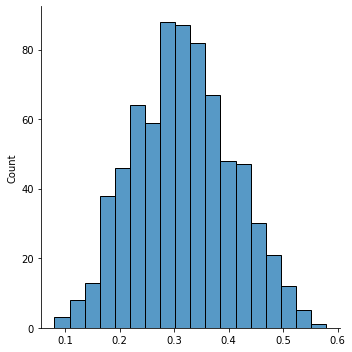

In [ ]:
sns.displot(pipe.predict_proba(X_val)[:, 1]);

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


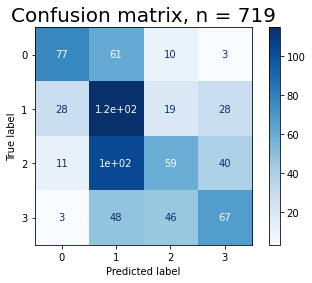

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=20)
plt.show()

In [ ]:
cm = pcm.confusion_matrix
cm

array([[ 77,  61,  10,   3],
       [ 28, 115,  19,  28],
       [ 11, 104,  59,  40],
       [  3,  48,  46,  67]])

In [ ]:
TP = cm[0][0] + cm[1][1] + cm[1][0] + cm[0][1]
TN = cm[2][2] + cm[2][3] + cm[3][2] + cm[3][3]
FP = cm[2][0] + cm[3][0] + cm[2][1] + cm[3][1]
FN = cm[0][2] + cm[0][3] + cm[1][2] + cm[1][3]
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
Beta = 1
F_score = (1+Beta**2) * (Precision * Recall) / (Beta**2 * Precision + Recall)
print('Precision = ',Precision)
print('Recall = ',Recall)
print('F1 score = ', F_score)
# 틀림 : 계산 우짜는지 모르겠음 그냥 함수 먹입시다!

Precision =  0.6286353467561522
Recall =  0.8240469208211144
F1 score =  0.7131979695431473


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.65      0.51      0.57       151
           1       0.35      0.61      0.44       190
           2       0.44      0.28      0.34       214
           3       0.49      0.41      0.44       164

    accuracy                           0.44       719
   macro avg       0.48      0.45      0.45       719
weighted avg       0.47      0.44      0.44       719



0,1,2,3 으로 나눠지게되서 THRESHOLD 조정은 힘들것같다.

In [ ]:
# 모델 (XGBClassifier) 학습 
pipe = make_pipeline(
    OrdinalEncoder(),  
    SimpleImputer(), 
    XGBClassifier(n_estimators=100, min_child_weight=1)
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
pred = pipe.predict(X_val)

훈련 정확도:  0.7552816901408451
검증 정확도:  0.41585535465924894


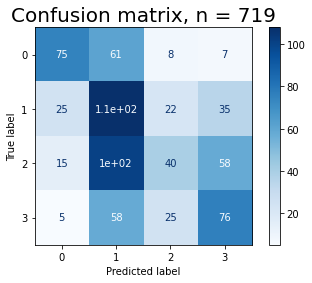

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=20)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.62      0.50      0.55       151
           1       0.33      0.57      0.42       190
           2       0.42      0.19      0.26       214
           3       0.43      0.46      0.45       164

    accuracy                           0.42       719
   macro avg       0.45      0.43      0.42       719
weighted avg       0.44      0.42      0.41       719



지금봐서는 랜덤포레스트가 나은듯 싶다.

##6. Random Forest Parameter Tuning

In [ ]:
# 기존 모델 (RandomForestClassifier) 학습 
pipe = make_pipeline(
    OrdinalEncoder(),  
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, max_depth=25, min_samples_leaf=3, random_state=2, oob_score=True)
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
pred = pipe.predict(X_val)

훈련 정확도:  0.9882629107981221
검증 정확도:  0.4422809457579972


In [ ]:
from scipy.stats import randint, uniform
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=2)
)
dists = {
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1)
}
clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)
clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.8min finished


In [ ]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 0.9251336514552683, 'randomforestclassifier__n_estimators': 251, 'simpleimputer__strategy': 'median'}
MAE:  0.9049295774647889


In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,26,5,13,32,2,36,29,11,16,43,40,47,38,22,23,31,15,24,35,49,21,28,17,8,42,37,7,4,41,12,0,14,30,33,1,27,44,45,48,18,20,34,25,6,3,46,10,39,19,9
mean_fit_time,3.30845,4.56652,1.23346,1.06575,8.39762,0.823435,6.94609,3.32467,1.65623,6.61296,4.06934,3.40215,1.23471,9.8818,6.14839,7.16504,2.81768,3.10471,4.59296,2.42016,4.72678,4.62606,3.35596,1.39286,1.69322,1.73256,4.3045,1.37202,5.85828,3.75354,2.3579,4.13297,0.904519,3.02204,1.74448,3.01227,2.10527,1.08707,2.12859,1.64745,1.05441,0.912591,0.916212,1.91267,1.17386,1.33896,1.79494,0.368109,1.23611,0.364419
std_fit_time,0.016823,0.0456511,0.00403629,0.00165159,0.293879,0.00327076,0.0806856,0.0432491,0.0232489,0.216483,0.113105,0.0984112,0.00940106,0.298361,0.187212,0.260304,0.0216145,0.115738,0.139133,0.221218,0.141095,0.140677,0.11212,0.0389178,0.0223197,0.0392173,0.0811419,0.0157503,0.193549,0.116915,0.0732379,0.10304,0.0294168,0.0906104,0.0504197,0.0838389,0.0244166,0.0240453,0.0147459,0.0267275,0.0278912,0.0312234,0.0194186,0.0643636,0.0177222,0.00578073,0.0234211,0.00653218,0.0204367,0.00735399
mean_score_time,0.0576727,0.0879703,0.0228299,0.0292599,0.0896144,0.0257354,0.0946911,0.0529745,0.0386907,0.0920653,0.0498573,0.0414782,0.0330213,0.096429,0.0606296,0.0867674,0.0732094,0.0534438,0.0497807,0.0709472,0.076486,0.0575578,0.0731951,0.026838,0.0249087,0.0290748,0.0856783,0.0332123,0.113086,0.0760527,0.0316737,0.0908995,0.0147264,0.0476778,0.0225701,0.0812946,0.0812732,0.0394944,0.0700214,0.058494,0.0337041,0.0343462,0.0376614,0.0756102,0.0602438,0.0709623,0.116714,0.0231457,0.0786105,0.0307959
std_score_time,0.00492374,0.00319467,0.000176652,0.006322,0.0039818,0.000718652,0.00891619,0.000669128,0.00146632,0.00643143,0.00562522,0.00347517,0.00128356,0.00587175,0.00365867,0.00868294,0.00256519,0.00608365,0.00283326,0.0155426,0.0112914,0.00384954,0.00871601,0.00236214,0.00308973,0.0023874,0.00396244,0.0016348,0.013785,0.00623098,0.00130454,0.00696831,0.000549045,0.00329931,0.0009253,0.0065449,0.00304364,0.00212776,0.00308549,0.00366302,0.00254044,0.00290797,0.00271302,0.00629253,0.00590483,0.00206906,0.0108654,0.00164458,0.00349517,0.00583305
param_randomforestclassifier__max_depth,5,5,5,5,20,5,10,10,5,20,15,15,5,None,20,20,5,20,None,5,15,None,None,15,15,15,10,10,None,None,None,None,None,20,15,15,10,20,10,20,15,None,None,None,15,10,None,20,20,5
param_randomforestclassifier__max_features,0.925134,0.824835,0.828682,0.602228,0.877338,0.434582,0.742404,0.61467,0.582488,0.668777,0.87426,0.797273,0.472443,0.943604,0.948951,0.830563,0.458592,0.616997,0.893936,0.372054,0.621748,0.783624,0.400083,0.482967,0.690319,0.577154,0.474733,0.395133,0.486419,0.401742,0.732014,0.363387,0.649607,0.544396,0.791333,0.285821,0.202495,0.185323,0.245919,0.187841,0.235299,0.205385,0.160519,0.163202,0.114843,0.123937,0.0169019,0.017231,0.0295739,0.0358556
param_randomforestclassifier__n_estimators,251,390,106,115,385,111,423,237,187,382,198,172,156,437,273,361,360,199,212,402,307,242,299,109,97,119,371,136,454,336,128,404,55,205,90,361,352,161,312,244,140,134,160,329,244,304,452,92,310,123
param_simpleimputer__strategy,median,mean,mean,mean,most_frequent,mean,mean,most_frequent,median,median,mean,mean,median,mean,median,median,median,median,median,median,most_frequent,most_frequent,most_frequent,median,most_frequent,mean,mean,mean,mean,median,most_frequent,mean,median,most_frequent,median,mean,most_frequent,median,most_frequent,median,mean,mean,mean,mean,most_frequent,mean,median,most_frequent,most_frequent,median
params,"{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier_

In [ ]:
pipe = clf.best_estimator_

In [ ]:
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))

훈련 정확도:  0.6255868544600939
검증 정확도:  0.4617524339360223


In [ ]:
X_test

,gd_enpr,gd_volm,gd_chag,sv_enpr,sv_volm,sv_chag,ob_enpr,ob_volm,ob_chag,ow_enpr,ow_volm,ow_chag,sp_enpr,sp_chag,kd_enpr,kd_chag,kr_enpr,kr_chag,us_enpr,us_chag,jk_enpr,jk_chag,uk_enpr,uk_chag
date,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-31,1288.200,0.000000,-0.820,15.6020,0.010000,-1.130,75.470000,34.700000,-0.580000,65.310000,666.49,-1.310000,2711.740000,1.090000,648.67,0.70,2.241,0.95,3.149,0.970,10.111300,0.340,1142.02,0.200000
2018-11-01,1312.200,0.010000,1.860,16.1060,0.590000,3.230,72.890000,360.160000,-3.420000,63.690000,790.29,-2.480000,2740.370000,1.060000,657.46,1.36,2.252,0.49,3.134,-0.480,9.975600,-1.340,1124.31,-1.550000
2018-11-02,1307.300,0.000000,-0.370,16.0880,0.940000,-0.110,72.830000,312.870000,-0.080000,63.140000,708.91,-0.860000,2723.060000,-0.630000,690.65,5.05,2.285,1.47,3.220,2.730,9.876800,-0.990,1118.10,-0.550000
2018-11-03,1307.000,0.016667,-0.270,15.4265,0.836667,-4.165,72.943333,285.626667,0.103333,63.126667,675.65,-0.593333,2728.143333,-0.233333,691.08,3.43,2.280,-0.22,3.215,1.215,9.884833,-0.580,1118.92,-0.293333
2018-11-04,1306.700,0.033333,-0.170,14.7650,0.733333,-8.220,73.056667,258.383333,0.286667,63.113333,642.39,-0.326667,2733.226667,0.163333,691.51,1.81,2.280,0.00,3.210,-0.300,9.892867,-0.170,1119.74,-0.036667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-28,1802.600,220.880000,0.210,24.1200,45.960000,-0.290,84.320000,118.140000,-0.310000,82.810000,491.59,0.180000,4596.420000,0.980000,1000.13,-0.87,2.391,-3.74,1.578,1.810,10.284900,-0.100,1168.44,-0.310000
2021-10-29,1783.900,254.510000,-1.040,23.9490,57.800000,-0.710,84.380000,22.770000,0.070000,83.570000,507.31,0.920000,4605.380000,0.190000,992.33,-0.78,2.583,8.03,1.561,-1.100,10.299700,0.140,1174.47,0.520000
2021-10-30,1782.575,254.510000,-0.595,23.8945,57.800000,-0.585,83.815000,22.770000,-0.635000,83.275000,507.31,0.105000,4605.380000,0.190000,994.41,-0.31,2.563,-0.77,1.569,-0.045,10.290800,-0.015,1174.54,0.265000


In [ ]:
pred = pipe.predict(X_test)
pred

array([1, 3, 3, ..., 1, 1, 1])

In [ ]:
print('테스트 정확도: ', pipe.score(X_test, y_test))

테스트 정확도:  0.5202578268876611


In [ ]:
y_test[-10:].values

array([2, 2, 2, 3, 0, 0, 0, 0, 1, 2])

와우. 50% 이상이나 때려맞추는 결과!

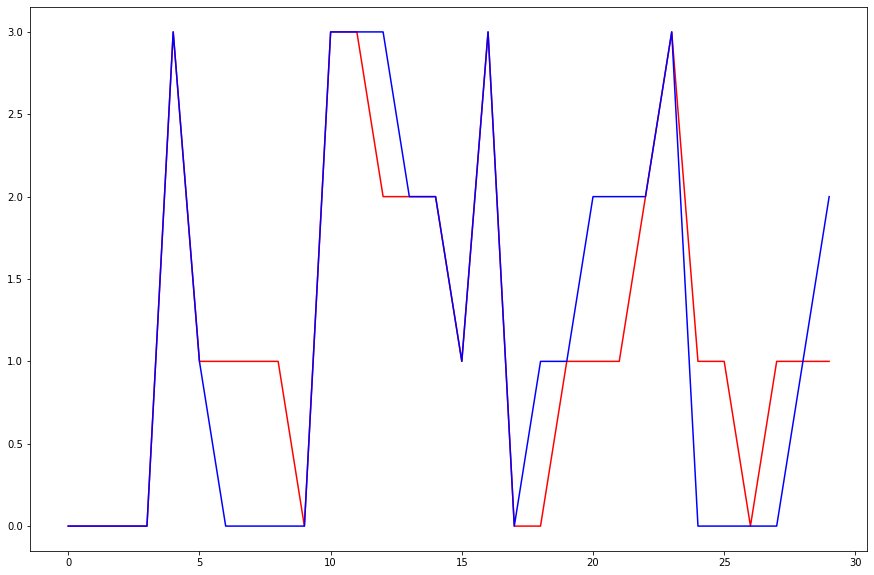

In [ ]:
fig = plt.figure(figsize=(15,10))

# 예측한 Point value
plt.plot(pred[-30:], color = 'red')

# 데이터 Point value
plt.plot(y_test[-30:].values, color = 'blue')

53% 정확도지만 추세 예측이고 1/4 확률이었기 때문에 쓸만해 보인다.\
 특히 30개의 데이터를 뜯어본 결과 1을 넘는 오차는 없었다는 점에서 감명받았다.

In [ ]:
row = X_test.iloc[[1]]  # 중첩 brackets을 사용하면 결과물이 DataFrame입니다
row

,gd_enpr,gd_volm,gd_chag,sv_enpr,sv_volm,sv_chag,ob_enpr,ob_volm,ob_chag,ow_enpr,ow_volm,ow_chag,sp_enpr,sp_chag,kd_enpr,kd_chag,kr_enpr,kr_chag,us_enpr,us_chag,jk_enpr,jk_chag,uk_enpr,uk_chag
date,,,,,,,,,,,,,,,,,,,,,,,,
2018-11-01,1312.2,0.01,1.86,16.106,0.59,3.23,72.89,360.16,-3.42,63.69,790.29,-2.48,2740.37,1.06,657.46,1.36,2.252,0.49,3.134,-0.48,9.9756,-1.34,1124.31,-1.55


In [ ]:
# 2018-11-01 실제 값
y_test.iloc[[1]] # 2번째 데이터를 사용했습니다


date
2018-11-01    1
Name: point, dtype: int64

In [ ]:
# 2018-11-01 모델 예측값
pred[0]

1

In [ ]:
!pip install shap

In [ ]:
pipe[2]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5,
                       max_features=0.9251336514552683, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=251, n_jobs=None, oob_score=False,
                       random_state=2, verbose=0, warm_start=False)

In [ ]:
row = X_test.iloc[[860]]
row

,gd_enpr,gd_volm,gd_chag,sv_enpr,sv_volm,sv_chag,ob_enpr,ob_volm,ob_chag,ow_enpr,ow_volm,ow_chag,sp_enpr,sp_chag,kd_enpr,kd_chag,kr_enpr,kr_chag,us_enpr,us_chag,jk_enpr,jk_chag,uk_enpr,uk_chag
date,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-17,1731.1,1.69,-0.24,26.113,0.18,0.21,68.0,309.76,-0.57,64.6,254.72,-0.31,3974.12,0.29,943.78,0.33,2.134,1.62,1.646,1.53,10.3005,-0.54,1121.21,-0.69


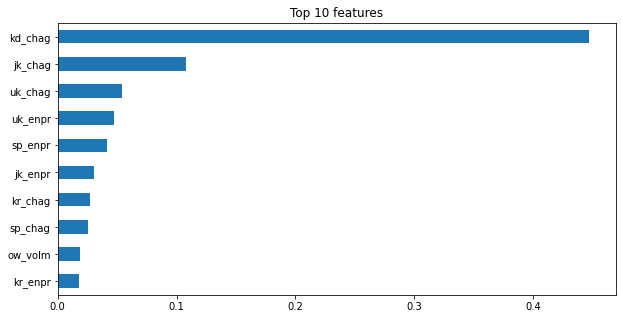

In [ ]:
# 특성 중요도
rf = pipe.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [ ]:
pipe.named_steps

{'ordinalencoder': OrdinalEncoder(cols=[], drop_invariant=False, handle_missing='value',
                handle_unknown='value', mapping=[], return_df=True, verbose=0),
 'randomforestclassifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=5,
                        max_features=0.9251336514552683, max_leaf_nodes=None,
                        max_samples=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=251, n_jobs=None, oob_score=False,
                        random_state=2, verbose=0, warm_start=False),
 'simpleimputer': SimpleImputer(add_indicator=False, copy=True, fill_value=None,
               missing_values=nan, strategy='median', verbose=0)}

In [ ]:
!pip install eli5

     |████████████████████████████████| 106 kB 41.2 MB/s 


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps['randomforestclassifier'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = pipe.named_steps['ordinalencoder'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val);

In [ ]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

uk_chag   -0.001113
sp_enpr   -0.000278
ow_enpr   -0.000278
gd_enpr    0.000278
sv_enpr    0.000834
kr_enpr    0.000834
jk_enpr    0.001113
us_enpr    0.001113
gd_volm    0.001947
ob_chag    0.001947
ob_enpr    0.001947
gd_chag    0.002225
sv_chag    0.002782
us_chag    0.003060
ob_volm    0.003338
kd_enpr    0.003894
sv_volm    0.004729
kr_chag    0.005285
uk_enpr    0.006398
ow_chag    0.007232
sp_chag    0.007232
ow_volm    0.008067
jk_chag    0.031154
kd_chag    0.197218
dtype: float64

In [ ]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.1972 ± 0.0402,kd_chag
0.0312 ± 0.0125,jk_chag
0.0081 ± 0.0059,ow_volm
0.0072 ± 0.0059,sp_chag
0.0072 ± 0.0037,ow_chag
0.0064 ± 0.0108,uk_enpr
0.0053 ± 0.0075,kr_chag
0.0047 ± 0.0028,sv_volm
0.0039 ± 0.0092,kd_enpr
0.0033 ± 0.0080,ob_volm


In [ ]:
print('특성 삭제 전:', X_train.shape, X_val.shape)

특성 삭제 전: (1704, 24) (719, 24)


In [ ]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]
X_test_selected = X_test[features]

In [ ]:
print('특성 삭제 후:', X_train_selected.shape, X_val_selected.shape, X_test_selected.shape)

특성 삭제 후: (1704, 18) (719, 18) (1086, 18)


In [ ]:
clf.best_params_

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__max_features': 0.9251336514552683,
 'randomforestclassifier__n_estimators': 251,
 'simpleimputer__strategy': 'median'}

In [ ]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(random_state=2, max_depth=5, max_features=0.9251336514552683, n_estimators=251)
)

pipe.fit(X_train_selected, y_train);

In [ ]:
print('테스트 정확도: ', pipe.score(X_test_selected, y_test))

테스트 정확도:  0.5138121546961326


In [ ]:
pred2 = pipe.predict(X_test_selected)
pred2

array([2, 3, 3, ..., 1, 1, 1])

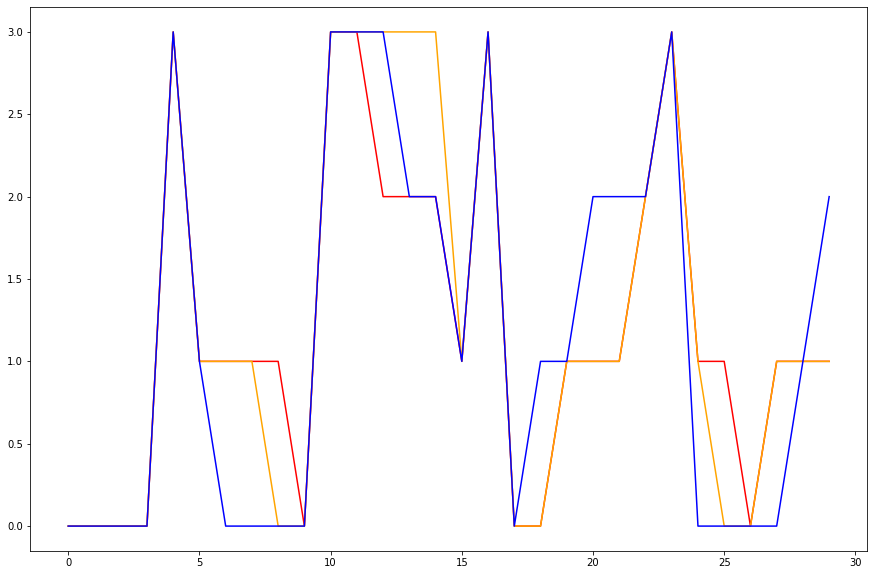

In [ ]:
fig = plt.figure(figsize=(15,10))

# 처음 예측한 Point value
plt.plot(pred[-30:], color = 'red')


# Feature 줄이고 예측한 Point value
plt.plot(pred2[-30:], color = 'orange')

# 데이터 Point value
plt.plot(y_test[-30:].values, color = 'blue')

특성 6개가 빠지고 정확도가 소폭 감소했다. 굳이 뺄 필요는 없을듯?

##7. Validation

ARIMA 모델과 Random Forest 모델을 테스트 해 봤고, 결과는 만족할만한 수준이었다. \
이제 합쳐서 검증을 진행해보자!
 1. 데이터 분할
  - Train / Test
  - 시점 : 2020.5.5

 2. 타겟 누수 확인

 3. ARIMA 적용

 4. Random Forest 적용

 5. 결과값 확인

데이터 분할

In [ ]:
df = df2

In [ ]:
train = cut_data(df, 0 , '2020-05-05')
test = cut_data(df, '2020-05-06', 0)
print('shape : ', train.shape, test.shape)

target = 'point'

X_train = train[train.drop(columns=[target]).columns]
y_train = train[target]

X_test = test[test.drop(columns=[target]).columns]
y_test = test[target]


print('shape : ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

shape :  (2970, 27) (539, 27)
shape :  (2970, 26) (539, 26) (2970,) (539,)


In [ ]:
X_train.head()

,gd_enpr,gd_volm,gd_chag,sv_enpr,sv_volm,sv_chag,ob_enpr,ob_volm,ob_chag,ow_enpr,ow_volm,ow_chag,sp_enpr,sp_chag,kd_enpr,kd_chag,kp_enpr,kp_chag,kr_enpr,kr_chag,us_enpr,us_chag,jk_enpr,jk_chag,uk_enpr,uk_chag
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-10-04,1614.70,0.160,-2.49,29.795,0.04,-3.11,99.790,264.830,-1.89,75.670,428.110,-2.50,1123.950,2.250,436.130,-3.010,1706.190,-3.590,3.80,-3.31,1.8170,3.890,15.59240,1.150,1198.900,1.560
2011-10-05,1640.30,0.110,1.59,30.317,0.18,1.75,102.730,215.940,2.95,79.680,336.070,5.30,1144.030,1.790,421.180,-3.430,1666.520,-2.330,3.78,-0.53,1.8910,4.070,15.46080,-0.840,1187.000,-0.990
2011-10-06,1651.90,0.040,0.71,31.970,0.01,5.45,105.730,192.570,2.92,82.590,386.090,3.65,1164.970,1.830,431.180,2.370,1710.320,2.630,3.81,0.79,1.9920,5.340,15.43820,-0.150,1183.950,-0.260
2011-10-07,1634.50,0.070,-1.05,30.958,0.06,-3.17,105.880,170.250,0.14,82.980,377.540,0.47,1155.460,-0.820,442.640,2.660,1759.770,2.890,3.82,0.26,2.0750,4.170,15.26130,-1.150,1171.000,-1.090
2011-10-09,1652.05,0.065,0.55,31.685,0.06,2.35,107.415,166.435,1.52,84.195,321.185,1.70,1175.175,1.295,448.275,2.605,1763.105,1.635,3.83,0.39,2.0725,1.955,15.24885,-0.655,1169.475,-0.675


ARIMA 모델 적용

In [ ]:
X_train.ob_enpr

date
2011-10-04     99.790000
2011-10-05    102.730000
2011-10-06    105.730000
2011-10-07    105.880000
2011-10-09    107.415000
                 ...    
2020-05-01     26.440000
2020-05-02     26.693333
2020-05-03     26.946667
2020-05-04     27.200000
2020-05-05     30.970000
Name: ob_enpr, Length: 2970, dtype: float64

In [ ]:
from tqdm import notebook

X_train_pred = pd.DataFrame([])
for col in notebook.tqdm(X_train.columns, desc='Progress'):
  X_train_pred[col] = arima(X_train[col],30)
  print('Now processing : ',col)

In [ ]:
from tqdm import notebook

X_test_pred = pd.DataFrame([])
for col in notebook.tqdm(X_test.columns, desc='Progress'):
  X_test_pred[col] = arima(X_test[col],30)
  print('Now processing : ',col)

In [ ]:
X_train_pred.head()

,gd_enpr,gd_volm,gd_chag,sv_enpr,sv_volm,sv_chag,ob_enpr,ob_volm,ob_chag,ow_enpr,ow_volm,ow_chag,sp_enpr,sp_chag,kd_enpr,kd_chag,kp_enpr,kp_chag,kr_enpr,kr_chag,us_enpr,us_chag,jk_enpr,jk_chag,uk_enpr,uk_chag
0,1738.543570,0.312236,-0.205259,15.382936,0.611075,-0.932171,31.057659,254.879364,4.117675,23.353392,455.770625,15.603318,2869.628123,0.028231,651.107714,0.339122,1911.392222,-0.182754,1.494410,-0.080934,0.661881,0.514286,11.463347,0.043761,1222.341035,-0.046808
1,1737.332603,0.462531,-0.059776,15.272261,0.747872,-0.795928,31.100881,246.473466,1.545198,21.773414,504.588305,3.813443,2867.591168,0.078781,652.121901,0.135597,1912.035794,-0.070323,1.493033,0.033280,0.660715,-1.148269,11.462142,0.054376,1221.983875,-0.015443
2,1736.832896,0.340709,0.002311,15.184743,0.909355,-0.426757,31.179541,240.424576,0.726879,20.339973,544.206067,-4.894826,2872.540613,-0.076230,652.852539,0.004806,1912.609958,-0.064104,1.493193,-0.060373,0.659783,-0.985226,11.461406,0.057113,1221.856592,0.008616
3,1736.666082,0.473217,0.079119,15.169088,0.894173,-0.307203,31.214230,236.071789,0.386603,19.463938,570.702178,-8.428934,2867.378435,0.049780,653.187619,0.004204,1914.632582,-0.036676,1.492380,0.033216,0.658940,-0.494113,11.460862,0.057775,1221.502178,0.023124
4,1736.629991,0.346236,0.055176,15.218993,0.958455,-0.303977,31.284797,232.939521,0.206937,19.336096,585.766441,-8.478707,2874.717041,-0.067923,653.194041,-0.040907,1915.021923,-0.052339,1.490910,-0.058685,0.658180,-0.263231,11.460242,0.057962,1221.376561,0.028764


In [ ]:
X_test_pred.head()

,gd_enpr,gd_volm,gd_chag,sv_enpr,sv_volm,sv_chag,ob_enpr,ob_volm,ob_chag,ow_enpr,ow_volm,ow_chag,sp_enpr,sp_chag,kd_enpr,kd_chag,kp_enpr,kp_chag,kr_enpr,kr_chag,us_enpr,us_chag,jk_enpr,jk_chag,uk_enpr,uk_chag
0,1785.993692,244.311040,0.064183,23.947055,57.773672,-0.120935,83.799094,88.065232,0.259686,83.415500,483.997038,0.185436,4611.293827,0.077643,1000.152201,0.122450,2985.807694,-0.018509,2.513384,0.566954,1.565047,0.124679,10.297722,0.051645,1177.447866,0.112021
1,1786.759763,240.624902,0.027286,23.971557,57.747730,-0.168768,83.980424,136.664664,0.257541,83.446109,462.648278,0.277127,4615.711560,0.065506,1001.740988,0.016073,2992.072039,-0.029082,2.525343,0.121842,1.567181,0.230566,10.297062,0.030200,1177.469106,0.076670
2,1787.042987,237.619154,0.016559,23.990812,57.789549,-0.172665,84.228830,170.844341,0.233757,83.548288,450.173853,0.198043,4622.055473,0.044788,1003.312485,-0.116352,2990.630222,-0.111833,2.529431,0.316929,1.569093,0.264562,10.294679,0.011046,1177.261825,0.067901
3,1787.243545,236.412385,0.013440,24.010245,57.843284,-0.172784,84.323302,196.635665,0.064665,83.739070,437.084453,0.274392,4626.804990,0.045577,1004.852772,-0.086629,2987.846814,-0.089969,2.527584,0.148183,1.568639,0.275477,10.292439,0.012768,1177.277446,0.066296
4,1787.282743,235.682500,0.012534,24.027765,57.920063,-0.172967,84.511874,214.502049,0.153181,83.754731,430.845271,0.198072,4632.567861,0.040877,1006.354186,-0.152321,2991.759851,-0.121260,2.524390,0.313403,1.570715,0.278981,10.290042,0.008095,1177.076241,0.065854


Random Forest 모델 적용

In [ ]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(random_state=2, max_depth=5, max_features=0.9251336514552683, n_estimators=251)
)

pipe.fit(X_train, y_train);

In [ ]:
X_train

,gd_enpr,gd_volm,gd_chag,sv_enpr,sv_volm,sv_chag,ob_enpr,ob_volm,ob_chag,ow_enpr,ow_volm,ow_chag,sp_enpr,sp_chag,kd_enpr,kd_chag,kp_enpr,kp_chag,kr_enpr,kr_chag,us_enpr,us_chag,jk_enpr,jk_chag,uk_enpr,uk_chag
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-10-04,1614.700000,0.160000,-2.490000,29.795,0.040000,-3.110,99.790000,264.830000,-1.890000,75.670000,428.110,-2.500000,1123.950,2.250000,436.130,-3.010,1706.190,-3.590,3.800,-3.31,1.8170,3.890,15.592400,1.150,1198.900,1.560
2011-10-05,1640.300000,0.110000,1.590000,30.317,0.180000,1.750,102.730000,215.940000,2.950000,79.680000,336.070,5.300000,1144.030,1.790000,421.180,-3.430,1666.520,-2.330,3.780,-0.53,1.8910,4.070,15.460800,-0.840,1187.000,-0.990
2011-10-06,1651.900000,0.040000,0.710000,31.970,0.010000,5.450,105.730000,192.570000,2.920000,82.590000,386.090,3.650000,1164.970,1.830000,431.180,2.370,1710.320,2.630,3.810,0.79,1.9920,5.340,15.438200,-0.150,1183.950,-0.260
2011-10-07,1634.500000,0.070000,-1.050000,30.958,0.060000,-3.170,105.880000,170.250000,0.140000,82.980000,377.540,0.470000,1155.460,-0.820000,442.640,2.660,1759.770,2.890,3.820,0.26,2.0750,4.170,15.261300,-1.150,1171.000,-1.090
2011-10-09,1652.050000,0.065000,0.550000,31.685,0.060000,2.350,107.415000,166.435000,1.520000,84.195000,321.185,1.700000,1175.175,1.295000,448.275,2.605,1763.105,1.635,3.830,0.39,2.0725,1.955,15.248850,-0.655,1169.475,-0.675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01,1717.800000,0.010000,0.460000,15.312,0.000000,-0.120,26.440000,216.980000,4.630000,19.780000,403.200,4.990000,2830.710,-2.810000,643.872,-0.180,1926.684,-0.652,1.517,0.00,0.6180,-4.260,11.455100,1.240,1224.890,0.990
2020-05-02,1724.433333,0.016667,0.693333,15.141,0.013333,-1.175,26.693333,216.563333,4.043333,19.983333,372.630,4.353333,2834.720,-1.733333,643.218,-0.290,1916.246,-1.328,1.517,0.00,0.6180,-2.130,11.458833,0.860,1224.640,0.640
2020-05-03,1731.066667,0.023333,0.926667,14.970,0.026667,-2.230,26.946667,216.146667,3.456667,20.186667,342.060,3.716667,2838.730,-0.656667,642.564,-0.400,1905.808,-2.004,1.517,0.00,0.6180,0.000,11.462567,0.480,1224.390,0.290


In [ ]:
print('Train 정확도: ', pipe.score(X_train, y_train))
print('Test 정확도: ', pipe.score(X_test, y_test))

Train 정확도:  1.0
Test 정확도:  1.0


kp_enpr, kp_chag 특성을 제외하지 않아서 1.0 정확도가 나온다. 사실 저게 중요한건 아니니 예측 데이터에 먹여보자!

In [ ]:
pred1 = pipe.predict(X_train_pred)
pred1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
pred2 = pipe.predict(X_test_pred)
pred2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

답이없다! 0~3의 정수형 데이터라서 누가 더 잘나가는지 알아보기도 힘들다.

point feature는 포기하고, kp-chag, kp-enpr 만 예측해보자!

데이터

In [ ]:
train = cut_data(df, 0 , '2020-05-05')
test = cut_data(df, '2020-05-06', 0)
print('shape : ', train.shape, test.shape)

target1 = 'kp_enpr'
target2 = 'kp_chag'

y_train = train[target2]
y_test = test[target2]

train = train.drop(['kp_enpr','kp_chag'],axis =1)
test= test.drop(['kp_enpr','kp_chag'],axis =1)

X_train = train
X_test = test


print('shape : ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

shape :  (2970, 26) (539, 26)
shape :  (2970, 24) (539, 24) (2970,) (539,)


ARIMA 모델 적용

In [ ]:
from tqdm import notebook

X_train_pred = pd.DataFrame([])
for col in notebook.tqdm(X_train.columns, desc='Progress'):
  X_train_pred[col] = arima(X_train[col],30)
  print('Now processing : ',col)

In [ ]:
from tqdm import notebook

X_test_pred = pd.DataFrame([])
for col in notebook.tqdm(X_test.columns, desc='Progress'):
  X_test_pred[col] = arima(X_test[col],30)
  print('Now processing : ',col)

Random Forest Regressor 적용 (데이터 변경으로 하이퍼파라미터 튜닝도 해야함)

In [ ]:
y_train.describe()

count    2970.000000
mean       -0.001426
std         0.901492
min        -8.390000
25%        -0.410000
50%         0.027500
75%         0.460000
max         8.600000
Name: kp_chag, dtype: float64

In [ ]:
from scipy.stats import randint, uniform
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor

pipe = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(random_state=2)
)

dists = {
    'targetencoder__smoothing': [2.,20.,50.,60.,100.,500.,1000.], # int로 넣으면 error(bug)
    'targetencoder__min_samples_leaf': randint(1, 10),     
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1) # max_features
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.0min finished


In [ ]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

최적 하이퍼파라미터:  {'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 0.9512131606008405, 'randomforestregressor__n_estimators': 365, 'simpleimputer__strategy': 'mean', 'targetencoder__min_samples_leaf': 1, 'targetencoder__smoothing': 50.0}
MAE:  0.4892222263768966


In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,1,38,26,46,45,42,27,7,48,15,14,47,6,43,49,28,3,36,21,35,9,13,12,30,11,4,8,10,33,39,24,16,34,31,29,17,18,0,22,5,2,40,37,19,25,41,20,23,44,32
mean_fit_time,12.4932,1.76542,18.8475,23.2639,9.73111,14.8891,14.9021,8.28515,13.8318,1.90888,7.0271,9.00266,3.9075,15.3775,16.7049,1.09085,3.08512,2.25106,2.95183,11.6078,1.6586,9.48766,5.2611,4.80719,4.35989,4.42114,6.3238,7.18505,2.72053,4.45349,10.1779,1.60245,2.56631,1.22272,10.6672,4.20974,5.26884,14.6479,1.34427,2.54782,3.66185,2.4887,2.10884,0.83229,1.60996,1.06395,1.68273,0.498068,0.187848,1.5959
std_fit_time,0.0977628,0.011495,0.216976,0.28901,0.124187,0.217866,0.172986,0.0864483,0.0910254,0.0293204,0.0629732,0.154939,0.0665099,0.184705,1.50161,0.0180858,0.0357701,0.0452144,0.100929,0.185845,0.023039,0.0770564,0.162511,0.134855,0.0634428,0.074429,0.157718,0.163085,0.0229342,0.0648483,0.372621,0.0175382,0.0337595,0.030013,0.214801,0.041906,0.174413,0.329098,0.0140359,0.0838204,0.0842878,0.0486588,0.0217987,0.0139733,0.0317209,0.0147593,0.005312,0.00926357,0.00442727,0.0321655
mean_score_time,0.0773172,0.0148107,0.11257,0.135277,0.0580498,0.092053,0.0857974,0.0466932,0.0944143,0.0464816,0.0700183,0.112626,0.0251222,0.0952597,0.0935413,0.0224759,0.0503457,0.0550237,0.0499088,0.113448,0.0344144,0.0839584,0.0763278,0.0784624,0.048074,0.037197,0.0582796,0.0782329,0.0364239,0.0575037,0.11892,0.0371339,0.0202713,0.0213617,0.0912549,0.0585034,0.0766273,0.136494,0.0181511,0.0424136,0.0350579,0.0359197,0.0861963,0.0426237,0.074681,0.0507189,0.0818854,0.0271231,0.0106479,0.0764493
std_score_time,0.00355785,0.0005346,0.00410899,0.00332128,0.00445453,0.00770291,0.00584246,0.00294093,0.00461225,0.00798881,0.00334827,0.00887939,0.00110015,0.00614028,0.0124265,0.000498156,0.000923779,0.00717466,0.00531271,0.00632789,0.0026154,0.00829676,0.000314517,0.00738847,0.00180264,0.00322996,0.0027021,0.00445084,0.00202797,0.00155328,0.00507131,0.000521982,0.0014148,0.000379998,0.00750475,0.00768369,0.00970503,0.0150379,0.00136976,0.00700229,0.00169739,0.00220998,0.0179142,0.00339615,0.00593742,0.00539927,0.00987232,0.00249341,0.000121326,0.00123794
param_randomforestregressor__max_depth,10,10,15,20,15,15,20,20,10,5,5,15,15,15,15,5,5,15,None,15,15,10,20,20,5,None,20,None,10,10,None,5,15,5,15,15,None,20,15,None,20,15,10,20,20,15,15,5,5,10
param_randomforestregressor__max_features,0.951213,0.852657,0.991943,0.931568,0.975761,0.993833,0.940389,0.986977,0.850802,0.317626,0.784167,0.401006,0.893044,0.905652,0.951471,0.304383,0.38778,0.196541,0.263072,0.581345,0.264508,0.644929,0.34236,0.25667,0.690339,0.655122,0.561384,0.521405,0.411414,0.44814,0.427574,0.271243,0.785244,0.390906,0.658776,0.404279,0.372506,0.590645,0.43536,0.306305,0.541694,0.371394,0.0876212,0.0777559,0.0105623,0.0101619,0.0212757,0.0402827,0.067761,0.0771717
param_randomforestregressor__n_estimators,365,56,411,482,212,326,310,166,441,242,426,441,92,364,401,137,327,204,171,419,111,389,253,289,293,126,207,245,171,259,400,224,70,128,340,205,245,450,59,131,120,132,385,151,292,220,349,163,56,404
param_simpleimputer__strategy,mean,mean,median,median,median,median,mean,mean,mean,median,median,mean,median,mean,median,median,median,median,mean,mean,mean,median,median,mean,mean,mean,median,mean,median,median,median,median,mean,median,mean,median,median,median,median,mean,median,mean,mean,mean,mean,mean,mean,mean,median,mean
param_targetencoder__min_samples_leaf,1,2,2,8,2,6,2,1,1,7,3,8,3,3,4,1,3,3,5,2,8,1,3,8,7,6,8,1,2,6,7,4,1,1,2,6,3,6,8,4,8,8,7,4,1,5,6,9,9,7
param_targetencoder__smoothing,50,1000,2,500,20,50,1000,50,100,500,2,1000,2,2,500,60,2,100,60,500,500,20,100,1000,20,60,2,100,2,60,50,2,100,60,60,1000,2,20,100,1000,2,50,20,20,500,2,1000,20,50,20


In [ ]:
pipe = clf.best_estimator_

In [ ]:
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_test, y_test))

훈련 정확도:  0.8208140380476481
검증 정확도:  0.581460085357683


??????

In [ ]:
pred = pipe.predict(X_test)

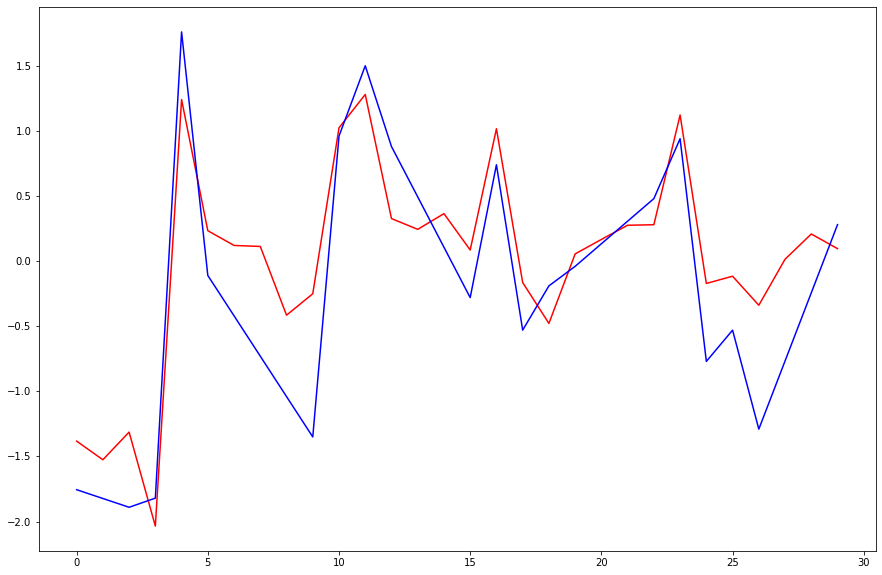

In [ ]:
fig = plt.figure(figsize=(15,10))

# 예측한 Point value
plt.plot(pred[-30:], color = 'red')

# 데이터 Point value
plt.plot(y_test[-30:].values, color = 'blue')

?? 꽤 정확하다..

In [ ]:
pred1 = pipe.predict(X_train_pred)
data1 = cut_data(df, '2020-05-06', '2020-06-04').kp_chag

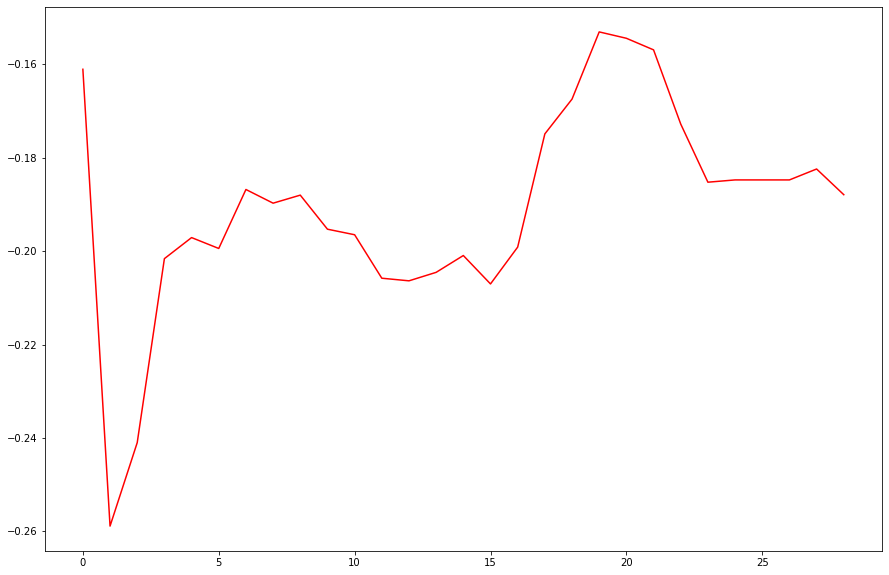

In [ ]:
fig = plt.figure(figsize=(15,10))

# 예측한 kp_chag (이전과 마찬가지로 분산이 줄어들긴했지만 일단 수치형으로 나왔다 => 조정하면 활용가능)
plt.plot(pred1[1:], color = 'red')

In [ ]:
prediction = pd.DataFrame({'value': pred1.tolist() })
prediction[:].describe()

,value
count,30.000000
mean,-0.185212
std,0.037216
min,-0.258876
25%,-0.200548
50%,-0.187945
75%,-0.176757
max,-0.028267


In [ ]:
temp_list = []
for i in prediction:
  print(i)

value


In [ ]:
temp_list = []
for i in prediction.value:
  temp = round(i,6)
  
  if temp <= -0.200548:
    n = 0
  elif temp <= 	-0.187945:
    n = 1
  elif temp < -0.176757:
    n = 2
  else:
    n = 3
  
  temp_list.append(n)

prediction['point'] = temp_list

In [ ]:
prediction

,value,point
0,-0.028267,3
1,-0.161038,3
2,-0.258876,0
3,-0.241003,0
4,-0.201596,0
5,-0.197085,1
6,-0.199415,1
7,-0.186783,2
8,-0.189714,1
9,-0.187992,1


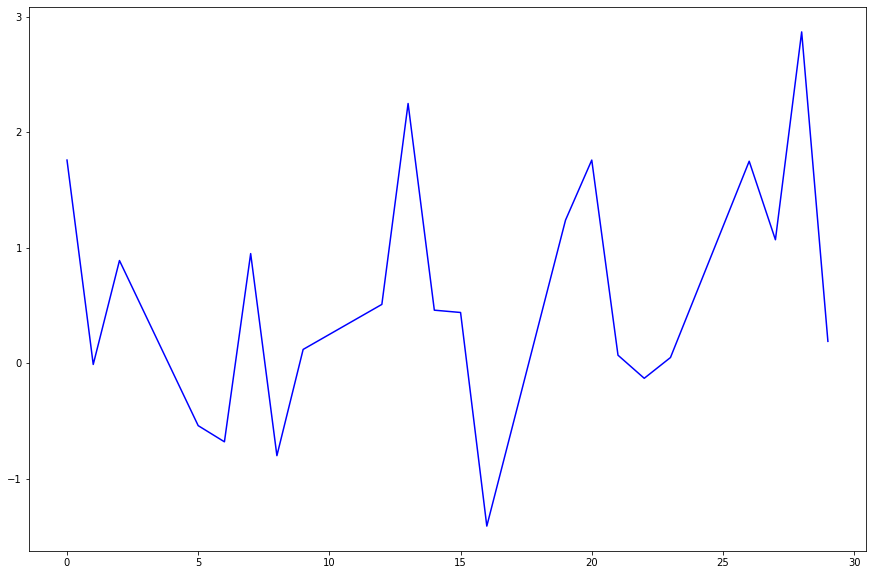

In [ ]:
fig = plt.figure(figsize=(15,10))

# 데이터 Point value
plt.plot(data1.values, color = 'blue')

In [ ]:
prediction1 = pd.DataFrame({'value': data1.tolist() })
prediction1[:].describe()

,value
count,30.000000
mean,0.514000
std,0.941340
min,-1.410000
25%,0.005000
50%,0.396667
75%,1.040000
max,2.870000


In [ ]:
temp_list = []
for i in prediction1.value:
  temp = round(i,6)
  
  if temp <= 0.005000:
    n = 0
  elif temp <= 	0.396667:
    n = 1
  elif temp < 1.040000:
    n = 2
  else:
    n = 3
  
  temp_list.append(n)

prediction1['point'] = temp_list

In [ ]:
prediction1

,value,point
0,1.760000,3
1,-0.010000,0
2,0.890000,2
3,0.413333,2
4,-0.063333,0
5,-0.540000,0
6,-0.680000,0
7,0.950000,2
8,-0.800000,0
9,0.120000,1


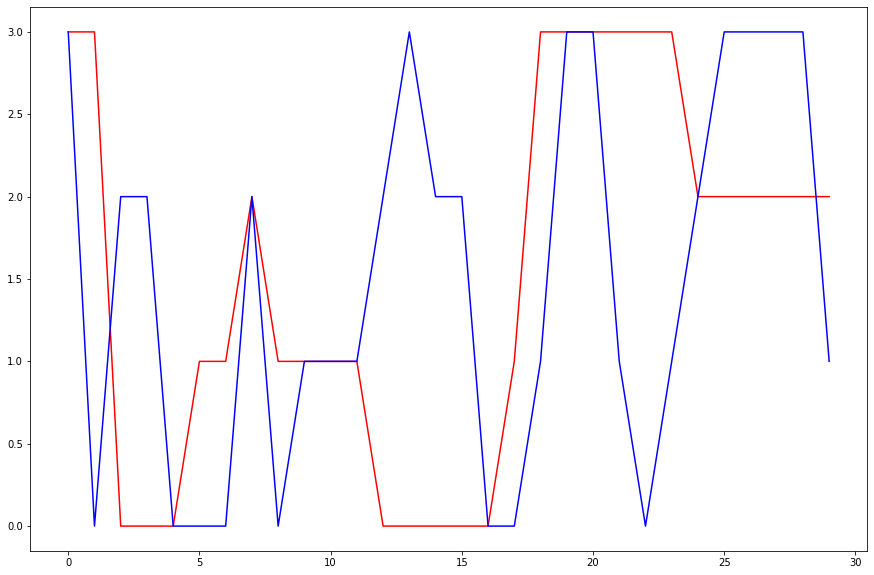

In [ ]:
fig = plt.figure(figsize=(15,10))

# 조정해준 예측값
plt.plot(prediction.point, color = 'red')

# 실제 데이터
plt.plot(prediction1.point, color = 'blue')

##8. Result

운이 좋아서 맞은건지... 도통 알기가 힘들다. Scale 을 맞춰준게 이정돈데, 실제 데이터는 맞추기 어렵다는걸 감안하면 ㅠㅠ

안타깝게도 코스피 2X 레버리지 및 인버스 ETF를 이용한 돈복사 버그는 실패한것같다. \
Feature 를 예측할 때 정밀도를 높일 수 있는 모델이 있는지 계속 찾아봐야 할 것 같다.

##9. Credit

돈 벌 생각에 신나서 하다가 급 우울해진사람 \
Name : 유태준 \
Tel : +82 010-4861-7125 \
Mail : dbxowns120@gmail.com